In [14]:
from sandbox.toolbox.models import ResNet112, ResNet56, ResNet20, ResNetBaby

import torch
import torchvision
import torchvision.transforms as transforms
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import random

from scipy.stats import kurtosis
import pywt
from scipy.stats import skew
from torchvision.transforms import GaussianBlur
import torch.fft as fft

device = 'cuda'
plt.rcParams['image.cmap'] = 'magma'

In [3]:
import os
import glob

root_dir = "experiments"
pth_files = glob.glob(os.path.join(root_dir, "**/Cifar100_ResNet*.pth"), recursive=True)
ds = torchvision.datasets.CIFAR100
mean, std = (0.5071, 0.4867, 0.4409), (0.267, 0.256, 0.276) 
transform_test = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(mean, std),
])

testset = ds(root='./data', train=False, download=True, transform=transform_test)
testloader = torch.utils.data.DataLoader(testset, batch_size=len(testset), shuffle=False, num_workers=0)

testloader_data = next(iter(testloader))
sample_idx_iter = iter(range(10000))

MODELS = {
    'ResNet112': ResNet112,
    'ResNet56': ResNet56,
    'ResNet20': ResNet20,
    'ResNetBaby': ResNetBaby
}

model_dict = {}
for file_path in pth_files:
    split = file_path.split('\\')[1:]
    model_name = split[1].split('_')[0] 
    model = MODELS[model_name](100).to(device)
    checkpoint = torch.load(file_path, weights_only=True)
    model.load_state_dict(checkpoint['weights'])
    if split[2].isdigit():
        model_dict.setdefault(model_name, {}).setdefault('None', {})[split[2]] = model
    else:
        model_dict.setdefault(model_name, {}).setdefault(split[2], {})[split[3]] = model



Files already downloaded and verified
Total parameters for ResNet112: 1,736,564
Total parameters for ResNet112: 1,736,564
Total parameters for ResNet112: 1,736,564
Total parameters for ResNet112: 1,736,564
Total parameters for ResNet112: 1,736,564
Total parameters for ResNet112: 1,736,564
Total parameters for ResNet112: 1,736,564
Total parameters for ResNet112: 1,736,564
Total parameters for ResNet112: 1,736,564
Total parameters for ResNet112: 1,736,564
Total parameters for ResNet20: 278,324
Total parameters for ResNet20: 278,324
Total parameters for ResNet20: 278,324
Total parameters for ResNet20: 278,324
Total parameters for ResNet20: 278,324
Total parameters for ResNet20: 278,324
Total parameters for ResNet20: 278,324
Total parameters for ResNet20: 278,324
Total parameters for ResNet20: 278,324
Total parameters for ResNet20: 278,324
Total parameters for ResNet20: 278,324
Total parameters for ResNet20: 278,324
Total parameters for ResNet20: 278,324
Total parameters for ResNet20: 278,

In [4]:
def get_batch(Model):
    Model.eval()
    inputs, targets = testloader_data 
    inputs, targets = inputs.to(device), targets.to(device)

    with torch.no_grad():
        outputs = Model(inputs)
    probs = torch.nn.functional.softmax(outputs[3], dim=1)
    confidence, predicted = torch.max(probs.data, 1)

    return [{
        'feature_map': outputs[2][i],
        'correct': predicted.eq(targets.data).cpu().float()[i].item() == 1.0,
        'predicted_class': np.array(testloader.dataset.classes)[predicted.data.cpu()][i],
        'correct_class': np.array(testloader.dataset.classes)[targets.data.cpu()][i],
        'confidence': confidence[i].item()
    } for i in range(10000)]

In [5]:
numb = '2' 
current = {
    '112N': model_dict['ResNet112']['None'][numb],
    '56N': model_dict['ResNet56']['None'][numb],
    '56F': model_dict['ResNet56']['ft'][numb],
    '20N': model_dict['ResNet20']['None'][numb],
    '20F': model_dict['ResNet20']['ft'][numb],
    'BN': model_dict['ResNetBaby']['None'][numb],
    'BF': model_dict['ResNetBaby']['ft'][numb],
}
batch = {}
for key in current:
    batch[key] = get_batch(current[key]) 


In [27]:
def print_sample_data(index, batch):
    batch_sample = batch[index]
    print(batch_sample['correct'], '| Predicetd', batch_sample['predicted_class'], '| Actual', batch_sample['correct_class'], ' | Confidence', f'{batch_sample['confidence'] * 100:.2f}%')

def process_feature_map(feature_map):
    fmap = feature_map.cpu()  # Shape: [1, C, H, W]
    fmap_avg = torch.mean(fmap, dim=1, keepdim=True)  # Shape: [1, 1, H, W]
    batch_size, _, h, w = fmap_avg.shape
    fmap_flat = fmap_avg.view(batch_size, -1)  # Shape: [1, H*W]
    tau = 0.5
    fmap_scaled = fmap_flat / tau
    fmap_softmax = torch.softmax(fmap_scaled, dim=1)  # Shape: [1, H*W]
    fmap_softmax = fmap_softmax * (h * w)  # Scale by H*W
    fmap_processed = fmap_softmax.view(1, 1, h, w)  # Shape: [1, 1, H, W]
    return fmap_processed[0, 0].unsqueeze(0).unsqueeze(0).to(device)

def visualize_processed_feature_map(index, batch):
    feature_map = batch[index]['feature_map'].unsqueeze(0)
    processed_fmap = process_feature_map(feature_map)[0,0].cpu()
    plt.figure(figsize=(5, 5))
    plt.imshow(processed_fmap,vmin=0)
    plt.axis('off')
    plt.show()

def visualize_channels(index, batch):
    feature_map = batch[index]['feature_map'].unsqueeze(0)
    fig, axs = plt.subplots(8, 8, figsize=(5, 5)) 
    for i in range(8):
        for j in range(8):
            axs[i, j].matshow(feature_map[0, (i * 8) + j].cpu(),vmin=0) 
            axs[i, j].axis('off')
    plt.show()

In [ ]:
feature_map = torch.randn(1, 64, 8, 8).to(device)
processed_fmap = process_feature_map(feature_map)[0,0].cpu()

plt.figure(figsize=(5, 5))
plt.imshow(processed_fmap, vmin=0)
plt.axis('off')
plt.show()

fig, axs = plt.subplots(8, 8, figsize=(5, 5)) 
for i in range(8):
    for j in range(8):
        axs[i, j].matshow(feature_map[0, (i * 8) + j].cpu(),vmin=0) 
        axs[i, j].axis('off')

112N
False | Predicetd otter | Actual camel  | Confidence 62.33%


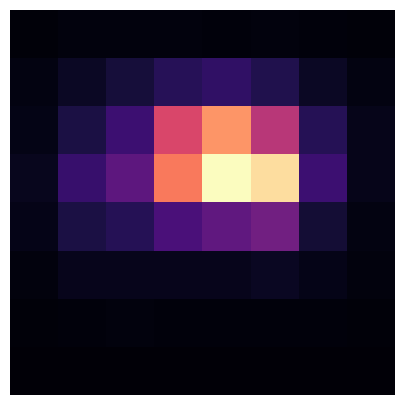

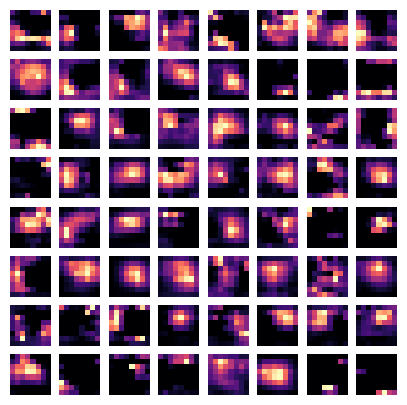

56N
True | Predicetd camel | Actual camel  | Confidence 28.15%


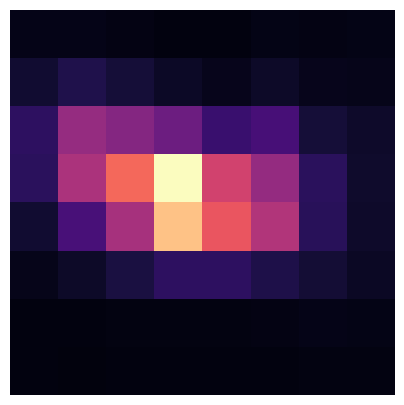

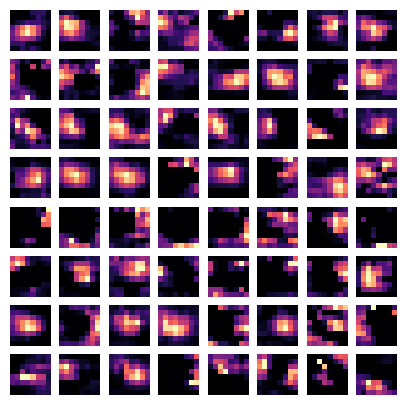

56F
True | Predicetd camel | Actual camel  | Confidence 93.04%


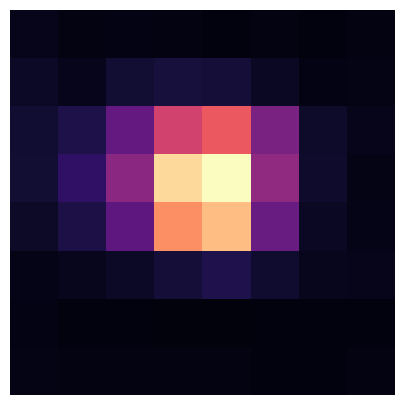

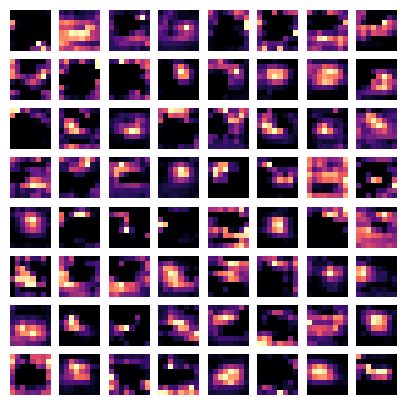

20N
True | Predicetd camel | Actual camel  | Confidence 36.15%


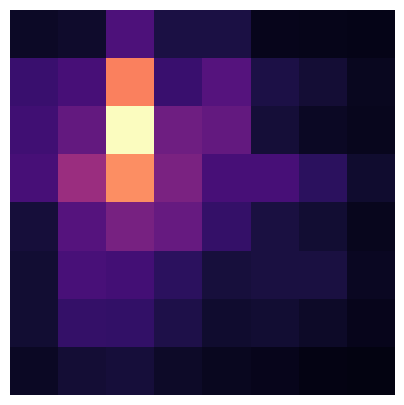

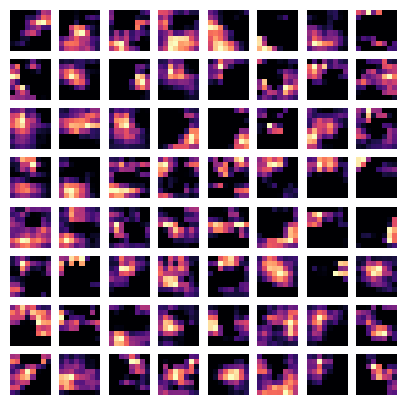

20F
True | Predicetd camel | Actual camel  | Confidence 15.83%


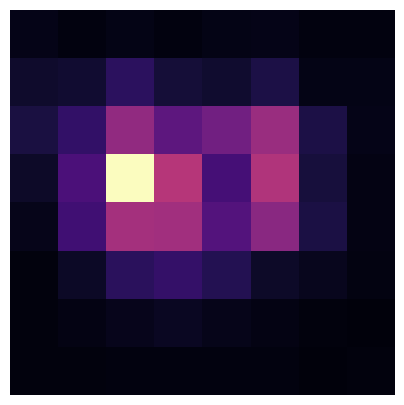

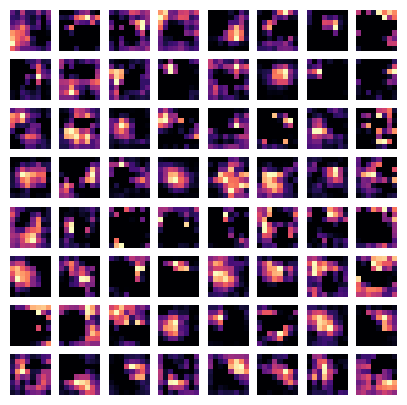

BN
True | Predicetd camel | Actual camel  | Confidence 39.45%


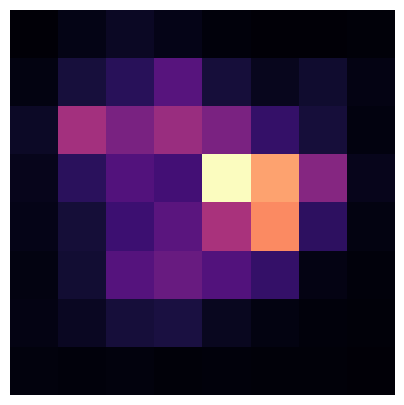

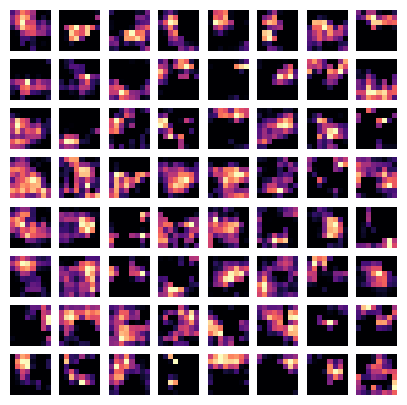

BF
True | Predicetd camel | Actual camel  | Confidence 95.74%


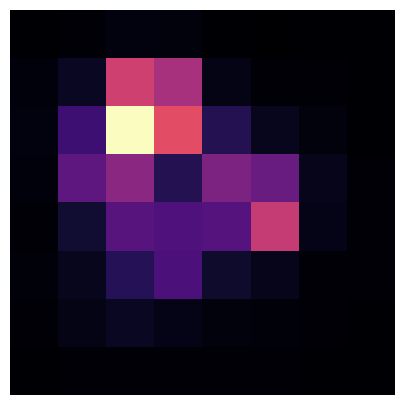

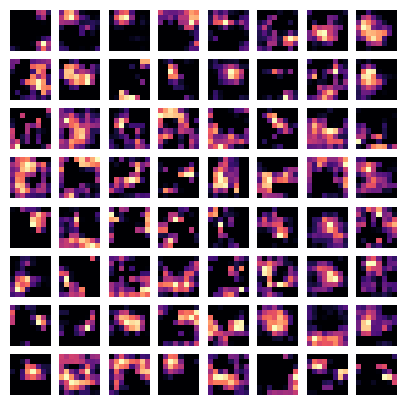

In [30]:
# sample_idx = next(sample_idx_iter)
sample_idx = random.randint(0,9999)
for key in batch:
    print(key)
    print_sample_data(sample_idx, batch[key])
    visualize_processed_feature_map(sample_idx, batch[key])
    visualize_channels(sample_idx, batch[key])

In [ ]:
def compute_wavelet_energy(feature_map, wavelet='db1', level=2):
    energies = []
    for c in range(feature_map.shape[1]):  # Iterate over channels
        fm_np = feature_map[0, c].detach().cpu().numpy()
        coeffs = pywt.wavedec2(fm_np, wavelet, level=level)
        high_freq_energy = 0
        for detail in coeffs[1:]:  # Each detail is a tuple of arrays
            for subband in detail:
                high_freq_energy += np.sum(subband**2)
        energies.append(high_freq_energy)
    
    energies = torch.tensor(energies)
    avg = energies.mean().item()
    # std = energies.std().item()
    return avg#, std

def compute_skewness(feature_map):
    flat_fm = feature_map.flatten().detach().cpu().numpy()
    skewness = skew(flat_fm)
    return skewness

def compute_lowpass_residuals(feature_map, kernel_size=3, sigma=1.0):
    blur = GaussianBlur(kernel_size, sigma)
    denoised_fm = blur(feature_map)
    residuals = torch.norm(feature_map - denoised_fm, p=2)
    return residuals.item()

def compute_frequency_entropy(feature_map):
    channels = feature_map.shape[1]
    entropies = []
    for c in range(channels):
        fm = feature_map[0, c]  
        fm_fft = fft.fft2(fm)
        power_spectrum = torch.abs(fm_fft)**2
        probs = power_spectrum / (power_spectrum.sum() + 1e-10)
        entropy = -torch.sum(probs * torch.log(probs + 1e-10))
        entropies.append(entropy)
    
    entropies = torch.tensor(entropies)
    avg = entropies.mean()
    # std = entropies.std()
    return avg.item()

def compute_iqr(feature_map):
    flat_fm = feature_map.flatten()
    q75, q25 = torch.quantile(flat_fm, torch.tensor([0.75, 0.25],device=device))
    iqr = q75 - q25
    return iqr.item()

def compute_high_freq_power(feature_map):
    channels = feature_map.shape[1]
    high_freq_powers = []
    for c in range(channels):
        fm = feature_map[0, c] 
        fm_fft = fft.fft2(fm)
        power_spectrum = torch.abs(fm_fft)**2
        high_freq_power = power_spectrum[int(fm.shape[0]/2):, int(fm.shape[1]/2):].sum()
        high_freq_powers.append(high_freq_power)
    
    high_freq_powers = torch.tensor(high_freq_powers)
    avg = high_freq_powers.mean().item()
    # std = high_freq_powers.std()
    return avg#, std

def compute_cv(feature_map):
    mean = torch.mean(feature_map)
    std = torch.std(feature_map)
    cv = mean / (std.abs() + 1e-10)
    return cv.item()

def compute_kurtosis(feature_map):
    flat_fm = feature_map.flatten().detach().cpu().numpy()
    return kurtosis(flat_fm)

def compute_entropy(feature_map): 
    feature_map = feature_map - feature_map.min()  
    sum_fm = feature_map.sum()
    if sum_fm == 0:  # Avoid division by zero
        return torch.tensor(0.0, device=feature_map.device)
    probs = feature_map / sum_fm
    entropy = -torch.sum(probs * torch.log(probs + 1e-10))
    return entropy.item()

metrics = {
    "Kurtosis": compute_kurtosis,
    "Wavelet High-Frequency Energy": compute_wavelet_energy,
    "Low-Pass Filter Residuals": compute_lowpass_residuals,
    "Frequency Entropy": compute_frequency_entropy,
    "IQR": compute_iqr,
    "High-Frequency Power": compute_high_freq_power,
    "Coefficient of Variation": compute_cv,
    "Skewness": compute_skewness,
    "Total Entropy": compute_entropy
}
    

In [ ]:
def analyze_feature_map_multiple_samples(batch_model, title, process=False, batch_size=10):
    results = {"Feature Map": title}
    for name, func in metrics.items():
        number = 0
        for i in range(batch_size):
            feature_map = batch_model[i]['feature_map'].unsqueeze(0)
            number += func(process_feature_map(feature_map) if process else feature_map)
        number /= batch_size
        results.update({name: round(number,4)})
    return results

def analyze_feature_map_to_table(feature_map_list, titles):
    rows = []
    for feature_map, title in zip(feature_map_list, titles):
        results = {"Feature Map": title}  # Add title as a column
        results.update({name: round(func(feature_map), 4) for name, func in metrics.items()})
        rows.append(results)
    return rows
    # try:
    #     df.to_excel("feature_map_metrics.xlsx", index=False)  # index=False keeps it as a column
    #     print("Saved to 'feature_map_metrics.xlsx'")
    # except ModuleNotFoundError:
    #     print("Error: Install 'openpyxl' to save to Excel (pip install openpyxl)")

In [ ]:
rows = []
temp = {"Feature Map": ""}
for name, func in metrics.items():
    temp.update({name: 0})


for key, value in batch.items():
    rows.append(analyze_feature_map_multiple_samples(batch[key], key))

rows.append(temp)
rows.append(temp)

for key, value in batch.items():
    rows.append(analyze_feature_map_multiple_samples(batch[key], key, True))

rows.append(temp)
rows.append(temp)


random_fmap = torch.randn(1, 64, 8, 8).to(device)
squashed_random_fmap = process_feature_map(random_fmap)
thing = analyze_feature_map_to_table([random_fmap, squashed_random_fmap], ['Random', 'Random Squashed'])

rows = rows + thing


df = pd.DataFrame(rows)
df.to_excel("metrics_fmaps.xlsx")
print(df.to_string(index=False))

    Feature Map  Kurtosis  Wavelet High-Frequency Energy  Low-Pass Filter Residuals  Frequency Entropy    IQR  High-Frequency Power  Coefficient of Variation  Skewness  Total Entropy
           112N   21.9540                        64.1199                    26.5214             2.2895 1.0842              348.7823                    0.5921    3.6616         7.3551
            56N   22.0971                        66.2911                    26.7762             2.3850 0.9939              317.6180                    0.5488    3.8263         7.2452
            56F   16.2649                       148.7538                    40.8681             2.4639 1.4372              784.0798                    0.5636    3.3931         7.2668
            20N   20.7059                        86.0710                    36.5019             2.4101 1.3427              575.7772                    0.5984    3.5104         7.3306
            20F   17.0140                       178.8812                    49.3990  